<a href="https://colab.research.google.com/github/InutilemMachina/DataSciRepo/blob/main/VibrationMapping_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vibration Mapping
The GPS coordinates and the triaxial accelerations of a passenger car have been recorded on the given route. The two sensors can be seen below, which were mounted on the cockpit. The current notebook presents how different measures of the vibration can be visualized on a map offering an insight into Road Vehicel Vibration (RVV) analysis. Namely, the Root Mean Square $RMS$ and the Maximum Absolute Accelerations $MAXA$ of the vertical vibrations will be plotted in each second of the journey.

## Importing and Pre-processing

The main task in this section is, how the two data sources can be merged. The GPS logger had a sampling frequency of $f_{s,GPS}=1 Hz$, the accelerometer $f_{s,VIB}=1024 Hz$. The start and endpoint in the experiment has been denoted by pressing a dedicated "tag" button on the GPS logger. That is, the tag `C` denotes the endpoints of the investigated interval.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = False)
%cd /content/drive/MyDrive/Colab Notebooks/VibrationMapping

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/VibrationMapping


## Prepare VIB signal

The acceleration file has been exported in `.mat` from the vibration data logger.

In [2]:
import scipy.io
mat = scipy.io.loadmat('/content/drive/MyDrive/Colab Notebooks/VibrationMapping/Measure_210218_102000.mat')
print(mat)

# Extract the four columns from the loaded data
column1 = mat['ticks']
column2 = mat['ax_17310032']
column3 = mat['ay_17310032']
column4 = mat['az_17310032']

# Create a DataFrame from the extracted columns
cols = {'ticks': column1.flatten(),
        'ax': column2.flatten(),
        'ay': column3.flatten(),
        'az': column4.flatten()}

import pandas as pd
vib = pd.DataFrame(cols)
fs = 1024  # Hz
vib['ticks'] /= fs  # convert ticks to sampled timepoints
vib

{'__header__': b'{vers. 5.0 MAT-FILE Creator: ILNumerics, 2014', '__version__': '1.0', '__globals__': [], 'ticks': array([[      0],
       [      1],
       [      2],
       ...,
       [2457597],
       [2457598],
       [2457599]], dtype=uint32), 'ax_17310032': array([[1.18691934],
       [1.25123305],
       [1.35574284],
       ...,
       [1.49240949],
       [1.46829185],
       [1.43613499]]), 'ay_17310032': array([[-0.04106363],
       [-0.04106363],
       [-0.04916503],
       ...,
       [ 0.35590479],
       [ 0.3234992 ],
       [ 0.25868803]]), 'az_17310032': array([[9.29696262],
       [9.362828  ],
       [9.2722631 ],
       ...,
       [9.20639773],
       [9.13229918],
       [9.09936649]])}


,ticks,ax,ay,az
0,0.000000,1.186919,-0.041064,9.296963
1,0.000977,1.251233,-0.041064,9.362828
2,0.001953,1.355743,-0.049165,9.272263
3,0.002930,1.420057,-0.049165,9.272263
4,0.003906,1.436135,-0.016759,9.486326
...,...,...,...,...
2457595,2399.995117,1.387900,0.347803,9.082900
2457596,2399.996094,1.452213,0.339702,9.082900
2457597,2399.997070,1.492409,0.355905,9.206398
2457598,2399.998047,1.468292,0.323499,9.132299


## Prepare GPS signal

The gps signal has beensaved as a `.csv` file.

In [3]:
gps = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/VibrationMapping/18111750.CSV')

In [4]:
# gps.info
# gps.describe()
# gps.describe(include = 'object')
# print(gps.dtypes)

In [5]:
gps.columns = ['ind', 'tag', 'date', 'time','lat','lon','hei','speed','heading'] # renaming for convenience
gps.drop(columns = ['date', 'hei', 'heading'], inplace = True) # drop some columns

In [6]:
gps['lat'] = gps['lat'].str.replace('N', '')  # remove N north string
gps['lon'] = gps['lon'].str.replace('E', '')  # remove E east string

In [7]:
# Convert the elapsed seconds column to int64 type:
gps['time'] = pd.to_datetime(gps['time'], format='%H%M%S')
gps['sec'] = gps['time'].dt.hour * 3600 + gps['time'].dt.minute * 60 + gps['time'].dt.second
gps['sec'] = gps['sec'].astype('int64')

columns = gps.columns.tolist() # Get the column names
columns.insert(1, columns.pop()) # Move the last column to the third position
gps = gps[columns] # Reorder the DataFrame with the new column order

In [8]:
gps['sec'] -=  gps.sec[0]  # Set time to start at zero

As already hinted, `tag = 'C'` are special points marking the start and end of measurement

In [9]:
# tag = 'C' are special points marking the start and end of measurement. 
gps.loc[gps['tag'] == 'C']
Cid = gps.loc[gps['tag'] == 'C'].index.tolist()
C1 = Cid[0]
C2 = Cid[1]
print('C1: ' + str(C1) + ', C2: ' + str(C2))
for i in Cid:
    print(gps.iloc[i-2:i+2])

# e.g. 
# start C_1 ind = 191 at time 11:21:04, that is at our "ind"=191 (taking pandas indexing irrelevant)
# end   C_2 ind = 2080 at time 11:52:32, that is at our "ind"=2080 (taking pandas indexing irrelevant)
# thus  C_1 ind and C_2 ind are here calculated from pandas row index, but a pleasant coincidence yields, 
# that we will use it directly in the gps.ind
# we see in the gps.sec column the corresponding seconds in relative time.

sec_1 = gps.at[C1, 'sec']
sec_2 = gps.at[C2, 'sec']
print('sec_1: ' + str(sec_1) + ', sec_2: ' + str(sec_2))

C1: 191, C2: 2080
     ind  sec tag                time        lat        lon  speed
189  190  189   T 1900-01-01 11:21:03  46.966373  18.934164   21.5
190  191  190   T 1900-01-01 11:21:04  46.966377  18.934090   20.6
191  192  190   C 1900-01-01 11:21:04  46.966377  18.934090   20.6
192  193  191   T 1900-01-01 11:21:05  46.966385  18.934015   20.2
       ind   sec tag                time        lat        lon  speed
2078  2079  2077   T 1900-01-01 11:52:31  46.806690  19.004541   32.3
2079  2080  2078   T 1900-01-01 11:52:32  46.806641  19.004620   28.3
2080  2081  2078   C 1900-01-01 11:52:32  46.806641  19.004620   28.3
2081  2082  2079   T 1900-01-01 11:52:33  46.806595  19.004683   25.6
sec_1: 190, sec_2: 2078


In [10]:
gps = gps[C1+1:C2]
gps

,ind,sec,tag,time,lat,lon,speed
192,193,191,T,1900-01-01 11:21:05,46.966385,18.934015,20.2
193,194,192,T,1900-01-01 11:21:06,46.966396,18.933935,24.8
194,195,193,T,1900-01-01 11:21:07,46.966404,18.933855,19.5
195,196,194,T,1900-01-01 11:21:08,46.966415,18.933798,14.8
196,197,195,T,1900-01-01 11:21:09,46.966431,18.933756,11.6
...,...,...,...,...,...,...,...
2075,2076,2074,T,1900-01-01 11:52:28,46.806889,19.004250,41.9
2076,2077,2075,T,1900-01-01 11:52:29,46.806816,19.004356,39.7
2077,2078,2076,T,1900-01-01 11:52:30,46.806751,19.004454,36.3
2078,2079,2077,T,1900-01-01 11:52:31,46.806690,19.004541,32.3


In [11]:
gps = gps.reset_index(drop=True) # Reset the index
gps['sec'] -=  gps.sec[0]  # Set time to start at zero AGAIN!
gps.drop(columns = ['ind', 'tag', 'time'], inplace = True)  # not necessary anymore
gps

,sec,lat,lon,speed
0,0,46.966385,18.934015,20.2
1,1,46.966396,18.933935,24.8
2,2,46.966404,18.933855,19.5
3,3,46.966415,18.933798,14.8
4,4,46.966431,18.933756,11.6
...,...,...,...,...
1883,1883,46.806889,19.004250,41.9
1884,1884,46.806816,19.004356,39.7
1885,1885,46.806751,19.004454,36.3
1886,1886,46.806690,19.004541,32.3


## Limit VIB signal

We need to constrain the vibration signal based on the measurement interval, derived from the GPS signal.

In [12]:
# where are those in vib
vib_start = vib[vib['ticks'] <= sec_1].index
vib_start_ix = vib_start[-1]
vib_end = vib[vib['ticks'] >= sec_2].index
vib_end_ix = vib_end[0]
print('in the series of: ' + str(len(vib)) + ', the start ix: ' + str(vib_start_ix) + ', and end ix: ' + str(vib_end_ix))

vib = vib[vib_start_ix:vib_end_ix]
vib = vib.reset_index(drop=True) # Reset the index
vib['ticks'] -=  vib.ticks[0]  # Set time to start at zero AGAIN!
vib

print('len(gps): ' + str(len(gps)) + ', len(gps): ' + str(len(gps)))  # eddig jó

vib['sec'] = vib['ticks'].astype(int)
columns = vib.columns.tolist()  # Get the column names
columns.insert(0, columns.pop())  # Move the last column to the third position
vib = vib[columns]  # Reorder the DataFrame with the new column order
vib

in the series of: 2457600, the start ix: 194560, and end ix: 2127872
len(gps): 1888, len(gps): 1888


,sec,ticks,ax,ay,az
0,0,0.000000,0.841233,-0.041064,8.654775
1,0,0.000977,0.809076,-0.041064,8.646542
2,0,0.001953,0.857312,-0.057266,8.654775
3,0,0.002930,1.074370,-0.130179,8.687708
4,0,0.003906,1.130645,-0.130179,8.827672
...,...,...,...,...,...
1933307,1887,1887.995117,1.428096,0.607048,9.198165
1933308,1887,1887.996094,1.428096,0.542237,9.156999
1933309,1887,1887.997070,1.436135,0.485527,9.140532
1933310,1887,1887.998047,1.412017,0.534136,9.156999


## Merge VIB and GPS

In [13]:
df = pd.merge(gps, vib, on = "sec", how = "outer")
df

,sec,lat,lon,speed,ticks,ax,ay,az
0,0,46.966385,18.934015,20.2,0.000000,0.841233,-0.041064,8.654775
1,0,46.966385,18.934015,20.2,0.000977,0.809076,-0.041064,8.646542
2,0,46.966385,18.934015,20.2,0.001953,0.857312,-0.057266,8.654775
3,0,46.966385,18.934015,20.2,0.002930,1.074370,-0.130179,8.687708
4,0,46.966385,18.934015,20.2,0.003906,1.130645,-0.130179,8.827672
...,...,...,...,...,...,...,...,...
1933307,1887,46.806641,19.004620,28.3,1887.995117,1.428096,0.607048,9.198165
1933308,1887,46.806641,19.004620,28.3,1887.996094,1.428096,0.542237,9.156999
1933309,1887,46.806641,19.004620,28.3,1887.997070,1.436135,0.485527,9.140532
1933310,1887,46.806641,19.004620,28.3,1887.998047,1.412017,0.534136,9.156999


# Signal processing of $a_z$

Since a DC MEMS sensor has logged the vibration signal, the vertical acceleration has a "more-or-less" constant offset, i.e., absolute acceleration. However, we will be interested in the relative acceleration in the corresponding direction. A simple solution will be the removal of the total average of $a_z$.

Our second task will be the removal of sections of the trip, where the car stood by, i.e., zero-speed intervals. This is not necessary in every case, but it will be done here. However, it will necessitate the rebuilding of time indices.

In [14]:
import numpy as np
df.az = df.az - np.mean(df.az)  # remove DC acceleration from vertical acceleration signal

df = df.drop(df[df.speed == 0.0].index)  # delete rows where speed is zero

### akkor viszont ujra kell építeni:
# - a ticks-t
# - sec és
# panda indexet is

N = len(df)
T = N/fs
ticks2 = np.linspace(0, int(T)-1, int(T)*fs)  # 0:1:T-1
df.ticks = ticks2

df.sec = df.ticks.astype(int)

df = df.reset_index(drop=True) # Reset the index
df

# >> viszont ez bezavarhat a map plotokba, mert a gps fájlból még nincs kiszedve a zerospeed szakaszok

gps = gps.drop(gps[gps.speed == 0.0].index)  # delete rows where speed is zero
gps = gps.reset_index(drop=True) # Reset the index

In [15]:
df.info
df.describe()
df.describe(include = 'object')
print(df.dtypes)

sec        int64
lat       object
lon       object
speed    float64
ticks    float64
ax       float64
ay       float64
az       float64
dtype: object


In [16]:
df['lat'] = df['lat'].astype(float)
df['lon'] = df['lon'].astype(float)

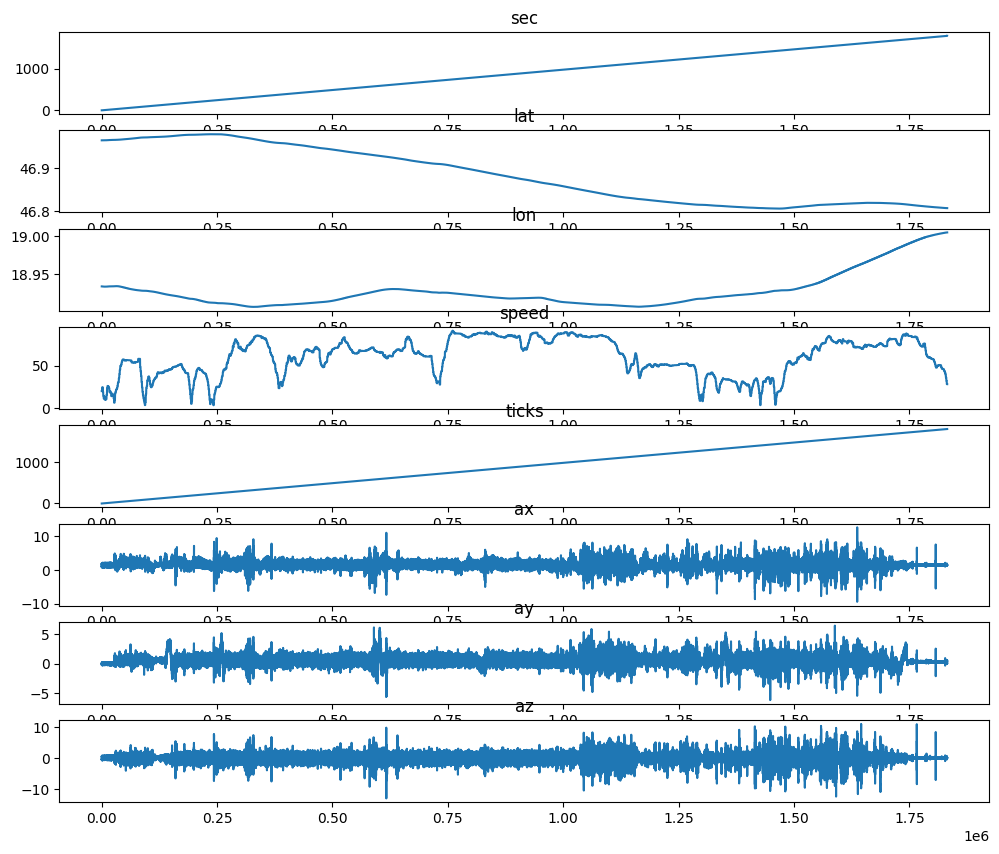

In [17]:
size = df.shape
columns = df.columns.tolist() # Get the column names

import matplotlib.pyplot as plt
fig, ax = plt.subplots(size[1], 1, figsize = [12,10])
axs = ax.flatten()
for i in range(size[1]):
    axs[i].plot(df.iloc[:, i])
    axs[i].set_title(columns[i])

# Visualize vibrations

Two simple statistics will be plotted here, defined in `rms` and `maxa`. The `for` loops using each function ensure that the statistics are computed per second of the journey, i.e., each statistic governs 1024 samples according to $f_{s,VIB}$.

In [18]:
# tul sok az adat a df-ben és nem tudja plottolni, ezért másodpercenkénti adatokat fogunk venni, mint pl a gps-ben
gps
gps['lat'] = gps['lat'].astype(float) # az object->float átalakítás lemaradt a gps táblábol
gps['lon'] = gps['lon'].astype(float)

In [19]:
def rms(x):
    """
    root mean square per second
    """
    sum_of_squares = sum([i**2 for i in x])
    mean_square = sum_of_squares / len(x)
    return mean_square**0.5 

# rms([1,2,3,1,2,3])

In [20]:
def maxa(x):
    """
    maximum absolute acceleration per second
    """
    ma = max([abs(i) for i in x])
    return ma

# maxa([-2,-3,1,4,-5])

In [21]:
rms_Z = []
for i in range(1, int(len(df)/fs + 1)):
    # print(str( (i-1)*fs) + ':' + str(i*fs-1) )
    rms_zi = rms( df['az'][int((i-1)*fs) : int(i*fs-1)] )
    rms_Z.append(rms_zi)

# plt.plot(rms_Z)

In [22]:
maxa_Z = []
for i in range(1, int(len(df)/fs + 1)):
    # print(str( (i-1)*fs) + ':' + str(i*fs-1) )
    maxa_zi = maxa( df['az'][int((i-1)*fs) : int(i*fs-1)] )
    maxa_Z.append(maxa_zi)

# plt.plot(maxa_Z)

In [23]:
import plotly.express as px

fig = px.scatter_mapbox(gps, lat="lat", lon="lon", size = maxa_Z, color=rms_Z, 
                        color_discrete_sequence=["fuchsia"], zoom=10, height=500,
                        title = 'RMS and absolute peak accelerations on the journey')
fig.update_layout(mapbox_style="carto-positron")  # 'open-street-map', 'white-bg', 'carto-positron', 'carto-darkmatter', 'stamen- terrain', 'stamen-toner', 'stamen-watercolor'.
fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0})
fig.update_coloraxes(colorbar_title_text='RMS_a_z')
fig.show()

We see in the live notebook:
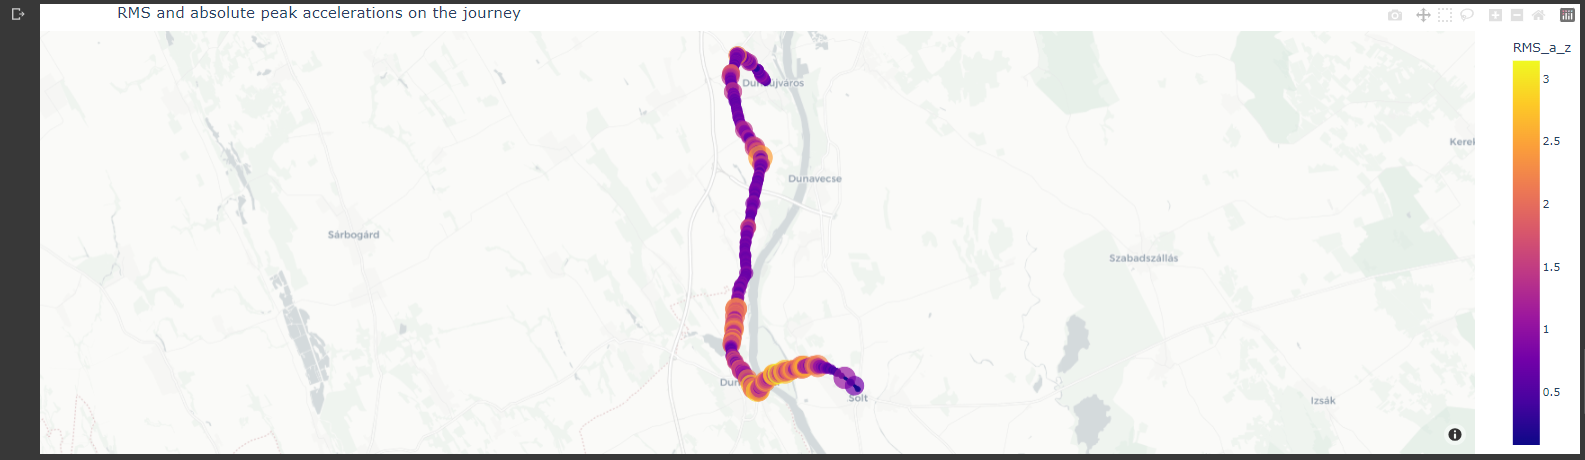

Text(0, 0.5, '$x_{stats} [m/s^2]$')

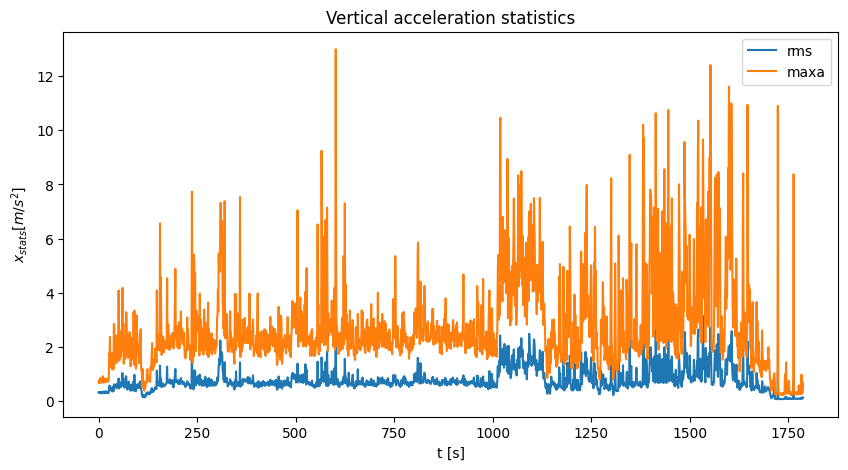

In [24]:
fig, ax = plt.subplots(1,1,figsize = [10,5])
ax.plot(rms_Z, '-', label='rms')
ax.plot(maxa_Z,'-', label='maxa')
ax.set_title('Vertical acceleration statistics')
ax.legend()
ax.set_xlabel('t [s]')
ax.set_ylabel('$x_{stats} [m/s^2]$')

Text(0, 0.5, '$rms_Z [m/s^2]$')

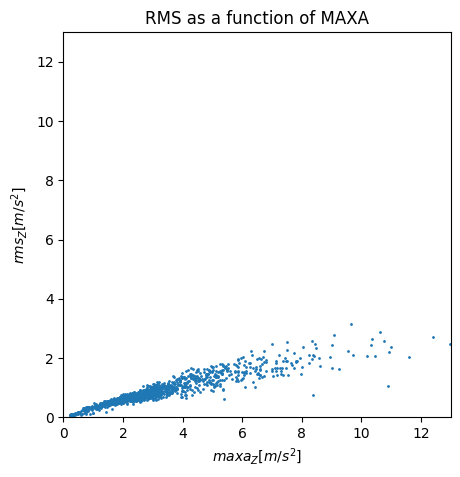

In [25]:
fig, ax = plt.subplots(1,1,figsize = [5,5])
ax.scatter(maxa_Z, rms_Z, 1)
ax.set_xlim([0,13])
ax.set_ylim([0,13])
ax.set_title('RMS as a function of MAXA')
ax.set_xlabel('$maxa_Z [m/s^2]$')
ax.set_ylabel('$rms_Z [m/s^2]$')